In [7]:
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv

load_dotenv()

model = ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0.1,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1",
    max_tokens=100
)

tools = []

agent = create_agent(
    model=model,
    tools=tools,
)

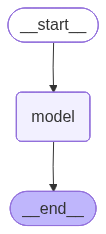

In [8]:
agent

In [9]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse


basic_model = ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0.1,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1",
    max_tokens=100
)

advanced_model = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0.1,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1",
    max_tokens=100
)

@wrap_model_call
def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
    """Choose model based on conversation complexity."""
    message_count = len(request.state["messages"])

    if message_count > 10:
        # Use an advanced model for longer conversations
        model = advanced_model
    else:
        model = basic_model

    request.model = model
    return handler(request)

agent = create_agent(
    model=basic_model,  # Default model
    tools=tools,
    middleware=[dynamic_model_selection]
)

In [10]:
from langchain.tools import tool
from langchain.agents import create_agent

@tool
def search(query: str) -> str:
    """A mock search tool that returns a fixed response."""
    return f"Search results for '{query}': [Result 1, Result 2, Result 3]"

@tool
def get_weather(location: str) -> str:
    """A mock weather tool that returns a fixed response."""
    return f"The weather in {location} is sunny with a high of 75°F."

agent = create_agent(
    model=model,
    tools=[search, get_weather]
)



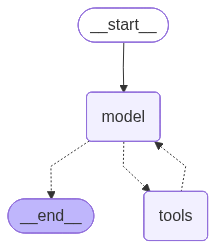

In [11]:
agent

In [12]:
from langchain.agents import create_agent
from langchain.agents.middleware import wrap_tool_call
from langchain_core.messages import ToolMessage


@wrap_tool_call
def handle_tool_errors(request, handler):
    """Handle tool execution errors with custom messages."""
    try:
        return handler(request)
    except Exception as e:
        # Return a custom error message to the model
        return ToolMessage(
            content=f"Tool error: Please check your input and try again. ({str(e)})",
            tool_call_id=request.tool_call["id"]
        )

agent = create_agent(
    model=model,
    tools=[search, get_weather],
    middleware=[handle_tool_errors]
)

In [14]:
from typing import TypedDict

from langchain.agents import create_agent
from langchain.agents.middleware import dynamic_prompt, ModelRequest


class Context(TypedDict):
    user_role: str

@dynamic_prompt
def user_role_prompt(request: ModelRequest) -> str:
    """Generate system prompt based on user role."""
    user_role = request.runtime.context.get("user_role", "user")
    base_prompt = "You are a helpful assistant."

    if user_role == "expert":
        return f"{base_prompt} Provide detailed technical responses."
    elif user_role == "beginner":
        return f"{base_prompt} Explain concepts simply and avoid jargon."

    return base_prompt

agent = create_agent(
    model=model,
    tools=[search],
    middleware=[user_role_prompt],
    context_schema=Context
)

# The system prompt will be set dynamically based on context
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Explain machine learning"}]},
    context={"user_role": "expert"}
)

In [15]:
result

{'messages': [HumanMessage(content='Explain machine learning', additional_kwargs={}, response_metadata={}, id='305c8c2e-b335-4c8f-96fe-e0a49fb3e7ba'),
  AIMessage(content='Machine learning (ML) is a subset of artificial intelligence (AI) focused on developing algorithms and statistical models that enable computers to improve their performance on a specific task through experience or data, without being explicitly programmed for every individual task.\n\n### Core Concepts of Machine Learning:\n\n1. **Data**: The foundational element of machine learning. Large quantities of data are used to train models. Data can be structured (like tables) or unstructured (like images, text, audio).\n\n2. **Model', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 58, 'total_tokens': 158, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prom

In [16]:
from pydantic import BaseModel
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy


class ContactInfo(BaseModel):
    name: str
    email: str
    phone: str

agent = create_agent(
    model=model,
    tools=[search],
    response_format=ToolStrategy(ContactInfo)
)

result = agent.invoke({
    "messages": [{"role": "user", "content": "Extract contact info from: John Doe, john@example.com, (555) 123-4567"}]
})

result["structured_response"]
# ContactInfo(name='John Doe', email='john@example.com', phone='(555) 123-4567')

ContactInfo(name='John Doe', email='john@example.com', phone='(555) 123-4567')